# Bagging - Bootstrapped Aggregation

When we implemented the single feature decision tree, we saw that essentially we were fitting a step function. We obtained a split point, and if the feature was smaller than the split point, we assigned one value and if it was bigger then we assigned a different value. We enabled more flexibility by implementing a decision tree that could handle multiple features and allowed us to specify a depth to learn more non-linear relationships

A slight issue with decision trees is that they can be sensitive to slight changes in the data. Depending on the precise locations of the split points, adding a new point could slightly change the location of the split points and send observations to completely different terminal nodes which might assign very different values. 

In this notebook we're going to implement a method called Bagging (Bootstrapped Aggregation), which can help us learn more smooth regression lines, so that we're less susceptible to jumps in predicted values

# Import Python Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy

# Generate data for Bagging

We're going to use a single feature variable so that we can easily visualise the model fitting process, but to avoid making it too easy for our decision trees we're going to make the relationship between feature and target horribly non-linear. We'll use the generating equation:

$$y = x \times (\text{sin}^2(x) - \text{cos}(x^2)) + N(0, \sigma^2)$$

Where $N(0, \sigma^2)$ is a sample from a zero-mean normal distribution


In [2]:
n = 2000
x = np.random.uniform(0, 4, n)

def generateY(x, sd):
    return x*(np.sin(x)**2 - np.cos(x**2)) + np.random.normal(0,sd,1)

y = [generateY(i,  0.5)[0] for i in x]

In [3]:
data = pd.DataFrame({'X':x, 'Y':y}) #Put the two arrays into a dataframe to make it easy to work with
data.head(10) #Inspect the first ten rows of our dataset 

,X,Y
0,0.415523,0.259258
1,2.754874,0.400224
2,3.937355,6.914714
3,1.920105,2.751311
4,0.375317,-1.026269
5,0.351128,0.201645
6,1.697144,2.697622
7,0.093953,-0.075520
8,2.572103,-0.808290
9,2.880272,1.504009


# Quickly plot the data so we know what it looks like

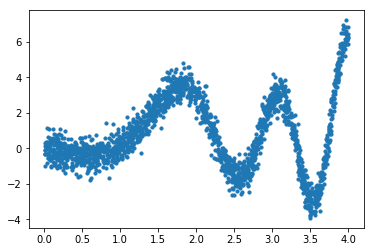

In [4]:
plt.scatter(data['X'], data['Y'], s = 10)
plt.show()

Hopefully we can see that fitting a single split point decision tree here will yield poor results. The data isn't well set up to be approximated by a step function, so a smoother function will be needed to achieve good results

# How does Bagging work?

Bagging is the simplest member in the family of ensemble methods. **If you're well versed in ensemble methods then you can skip reading this part and head to the coding part**. 

The general idea behind an ensemble method is that crowds are more often correct than individuals. To give an illustration as to why this statement is (sometimes) true, think of the popular gameshow *Who Wants To Be A Millionaire?*. The game challenges contestants to correctly answer 15 multiple choice questions, where each question has four answers for the contestant to select from. If a contestant gets stuck on a particular question, they can elect to Ask The Audience. Each member of the audience then submits their answer via an electronic device and the contestant is shown the proportions with which the audience chose the relative answers and then answers the question taking this information into account.

Why should the contestant listen to the audience? Let's say 1/3 of the audience know the correct answer with total certainty and the remaining 2/3 of the audience guess at random between the four answers. Under this framework, $\frac{1}{3} + \frac{1}{4} \times \frac{2}{3} = \frac{1}{2}$ of the audience will report the correct answer and each of the incorrect answers will be reported 16.6% of the time. Therefore, under this very simplified model, and assuming that the contestant is not paranoid that the audience is out to get them, they should choose the answer most favoured by the audience.

The WWTBAM? example is slightly different than the regression example that we're working with, and is of course totally devoid of rigour. A slightly more rigourous explanation is that the error in a model has two sources - bias and variance. A model which returns the average value of an ensemble of models will suffer from the same biases as the models in the ensemble, but by taking an average we reduce the variance component of the error (as the models which over-predict and those which under-predict should cancel each other out), leading to a model which in theory should have a smaller average error. To read more about the bias-variance decomposition and why ensemble methods work, I'd recommend section 14 of Bishop's PRML (available here: http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)

If we're going to adopt an ensemble-based approach, a very good question is: Where are we going to get our data from? If we had ten models in our ensemble and assigned a tenth of the training set to each model then the performance of each model might be drastically worse due to a lack of data and it might not be possible to get any more data. On the other hand if we use the same dataset to train each model, then each model will predict exactly the same thing, essentially rendering our ensemble approach pointless.

Bootstrapping allows us to have the best of both worlds. If you've not heard of it before, the Bootstrap is an old-fashioned statistical trick to get more bang for your buck from your data. In simple terms, if we have a dataset 

$$X = \{X_1, X_2, ..., X_n\}$$

then we can create a new dataset $X_{B_1}$ by taking samples from $X$. If we take $n$ samples from $X$ (with replacement), then $X_{B_1}$ is a different dataset but with a similar distribution of values to $X$. The process is supposed to imitate sampling from the true distribution which generated $X$.

The benefit of obtaining $X_{B_1}$, a dataset which is similar to $X$ but not quite the same is that we can fit a decision tree using $X_{B_1}$ and it will give slightly different results than if we had used $X$. We can bootstrap lots of times to obtain $X_{B_2}, X_{B_3}, ...,X_{B_b}$, each one a different dataset which will in turn give rise to a different decision tree.

To create a Bagged model, we simply aggregate the output of an ensemble of Bootstrapped models (hence the name: Bagging - Bootstrap AGGregatING)

In [5]:
class decisionTreeNode:
    
    def __init__(self,data, target, features, currentDepth): 
        self.left = None #Left child node
        self.right = None #Left child node
        self.currentDepth = currentDepth
        self.data = data 
        self.target = target
        self.features = features
        
        
        self.splitPointMesh = {}
        
        for feature in self.features:
            #We have a set of features and to determine how we're going to split this dataset 
            #we'll go through each feature in turn and find an optimal split point for that feature
            #Then we'll split using the feature which gives the smallest error for the dataset
            #(This is not necessarily an optimal strategy but the combinatorial space is too big to 
            #investigate every possible tree)
            
            #So the first point of that is defining a mesh for each feature
            
#             meshMin = np.sort(self.data[feature])[1] 
#             meshMax = np.sort(self.data[feature])[-2]

            meshMin = np.min(self.data[feature])
            meshMax = np.max(self.data[feature])
            self.splitPointMesh[feature] = np.linspace(meshMin, meshMax, 500)
    
    def computeMeansGivenSplitPoint(self, splitPoint, feature):
        #Given a split point, we want to split the training set in two
        #One containing all the points below the split point and one containing all the points above the split point
        #The means are then the means of the targets in those datasets and they are the values we want to return
        
        belowSplitPoint = self.data.loc[self.data[feature] < splitPoint][self.target].mean()
        aboveSplitPoint = self.data.loc[self.data[feature] >= splitPoint][self.target].mean()
        
        return belowSplitPoint, aboveSplitPoint
    
    def computeSquaredError(self, splitPoint, feature):
        #Once we have a split point and a set of means, we need to have some way of identifying whether it's 
        #a good split point or not
        
        #First apply compuuteMeansGivenSplitPoint to get the values for above and below the dataset
        #Then compute the sum of squared errors yielded by assigning the corresponding mean to each point in the training set
        #If we add these two sums of squares together then we have a single error number which indicates how good our split point is
        
        c0, c1 = self.computeMeansGivenSplitPoint(splitPoint, feature)
        
        #To get the value of errorBelow, subset the training set to the points below the split points
        #Then calculate the squared difference between target and c0 for each observation in the subset
        #Then sum them up (This can all be done in one line)
        
        errorBelow = np.sum((self.data.loc[self.data[feature] < splitPoint][self.target] - c0)**2) 
        
        #errorAbove works in the same way
        errorAbove = np.sum((self.data.loc[self.data[feature] >= splitPoint][self.target] - c1)**2) 
        
        totalError = errorBelow + errorAbove

        return totalError
    
    def createSplitDatasetsGivenSplitPointAndFeature(self, splitPoint, feature):
        #Given a split point, split the dataset up and return two datasets
        
        belowData = self.data.loc[self.data[feature] < splitPoint]
        aboveData = self.data.loc[self.data[feature] >= splitPoint]
        
        return belowData, aboveData
    

def fitDT(Node, maxDepth):
    
    
    if Node.currentDepth < maxDepth:
        #if node depth > max depth then we continue to split
        
        #Do splitting here
        #We want to find the best error for each of the features, then use that feature to do the splitting
        
        errors = {}
        for feature in Node.features:
            errors[feature] = [Node.computeSquaredError(splitPoint, feature) for splitPoint in Node.splitPointMesh[feature]]
            
        #Now we want to extract the feature and splitPoint which gave the best overall error
        currentBestError = min(errors[Node.features[0]]) + 1 #Initialise
        
        for feature in Node.features:
            if min(errors[feature]) < currentBestError:
                bestFeature = feature
                currentBestError = min(errors[feature])
                bestSplitPoint = Node.splitPointMesh[feature][np.argmin(errors[feature])]
                
                
        #Now we have the best feature to split on and the place where we should split it
        splitDataLeft, splitDataRight = Node.createSplitDatasetsGivenSplitPointAndFeature(bestSplitPoint, bestFeature)
        
        #Record the splitting process
        Node.featureSplitOn = bestFeature
        Node.bestSplitPoint = bestSplitPoint
        #print(bestFeature, bestSplitPoint)
        
        
        
        
        if Node.data.drop_duplicates().shape[0] > 1:
            Node.left = decisionTreeNode(splitDataLeft, Node.target, Node.features, Node.currentDepth + 1) #Define nodes on the levels below (increment depth by 1)
            Node.right = decisionTreeNode(splitDataRight, Node.target, Node.features, Node.currentDepth + 1)
            fitDT(Node.left, maxDepth) #The recursive part, which works exactly the same as we saw for the simpler example above
            fitDT(Node.right, maxDepth)
        else: #If there is only one example left in this dataset then there's no need to do any splitting
            Node.left = copy.deepcopy(Node)
            Node.right = copy.deepcopy(Node)
            Node.left.currentDepth = Node.currentDepth + 1
            Node.right.currentDepth = Node.currentDepth + 1
            fitDT(Node.left, maxDepth) #The recursive part, which works exactly the same as we saw for the simpler example above
            fitDT(Node.right, maxDepth)
            
        
    elif Node.currentDepth == maxDepth:
        #If we're at a terminal node then we need to return a value to predict
        #Don't need to do any splitting or anything like that, just want to return the mean value
        
        Node.prediction = Node.data[Node.target].mean()
            
def predictSingleExample(decisionTreeNode, xrow, maxDepth):
    #decisionTreeNode should be the root node of a fitted decision tree
    #maxDepth needs to be the same maxDepth as the fitted decision tree
    
    #x needs to be a pandas dataframe (with one or more rows) with the same column names as the features 
    #in the training set
    
    if decisionTreeNode.currentDepth < maxDepth:

        if xrow[decisionTreeNode.featureSplitOn] < decisionTreeNode.bestSplitPoint:
            return predictSingleExample(decisionTreeNode.left, xrow, maxDepth)
        else:
            return predictSingleExample(decisionTreeNode.right, xrow, maxDepth)
     

    elif decisionTreeNode.currentDepth == maxDepth:
        
        return decisionTreeNode.prediction

In [6]:
class baggedDecisionTree:
    
    def __init__(self, data, target, features, trainTestRatio = 0.9, maxDepth = 5):
        #data - a pandas dataset 
        #target - the name of the pandas column which contains the true labels
        #feature - the name of the pandas column which we will use to do the regression
        #trainTestRatio - the proportion of the entire dataset which we'll use for training
                    #   - the rest will be used for testing
        
        self.target = target
        self.features = features
        
        #Max Depth of decision tree
        self.maxDepth = maxDepth
        
        #Split up data into a training and testing set
        self.train, self.test = train_test_split(data, test_size=1-trainTestRatio) #We're doing the train/test split here
                                                                                 #Instead of in the DT
            
    
    def fitBaggedDT(self, numTrees = 50):
        
        self.forest = [] #List containing all of our decision trees
        
        for i in range(numTrees):
            
            if i % 1 == 0:
                print(f'Fitting decision Tree {i+1} of {numTrees}')
            
            #Bootstrap dataframe
            bootstrappedData = self.train.sample(frac = 1, replace = True)
            
            #Define a decision tree
            root = decisionTreeNode(bootstrappedData, self.target, self.features, 0) #Define root
            fitDT(root, self.maxDepth)
            
            self.forest.append(copy.deepcopy(root)) #Save the fitted decision tree in the forest
            
        return 0
    
    def predict(self, X):
        #X should be a pandas dataframe
        
        return np.mean(np.array([[predictSingleExample(root, row, self.maxDepth) for index, row in X.iterrows()] for root in self.forest]), axis = 0)


# Now let's fit a Bagged model!

We'll use a forest of five trees, each with a depth of 5.

In [7]:
bag = baggedDecisionTree(data, 'Y', ['X'], maxDepth = 5)
bag.fitBaggedDT(numTrees = 5)

Fitting decision Tree 1 of 5
Fitting decision Tree 2 of 5
Fitting decision Tree 3 of 5
Fitting decision Tree 4 of 5
Fitting decision Tree 5 of 5


0

In [8]:
bag.testPred = bag.predict(bag.test) #Predictions on the test set

## Now we want to see how our bagged decision tree stacks up against an individual decsion tree

There are far more rigourous ways to assess their relative performance but it can be quite instructive to visualise the regression lines of the bagged predictor compared to the trees that make up the ensemble

In [9]:
meshMin = np.min(bag.train[bag.features])
meshMax = np.max(bag.train[bag.features])
bag.regLineMesh = np.linspace(meshMin, meshMax, 1000) #We're going to evaluate our models lots of times 
                                                    #then draw a line between the points

bag.regLineDF = pd.DataFrame({'X':bag.regLineMesh.reshape(-1)}) #Put it into dataframe form so it can be fed to our predict function


In [10]:
bag.regLineDF['Pred'] = bag.predict(bag.regLineDF) #Predictions from the bagged predictor

#Now do predictions for each tree in the forest

for i in range(len(bag.forest)): #bag.forest contains each decision tree in the ensemble
    bag.regLineDF[f'Pred{i}'] = [predictSingleExample(bag.forest[i], row, bag.maxDepth) for index, row in bag.regLineDF.iterrows()]



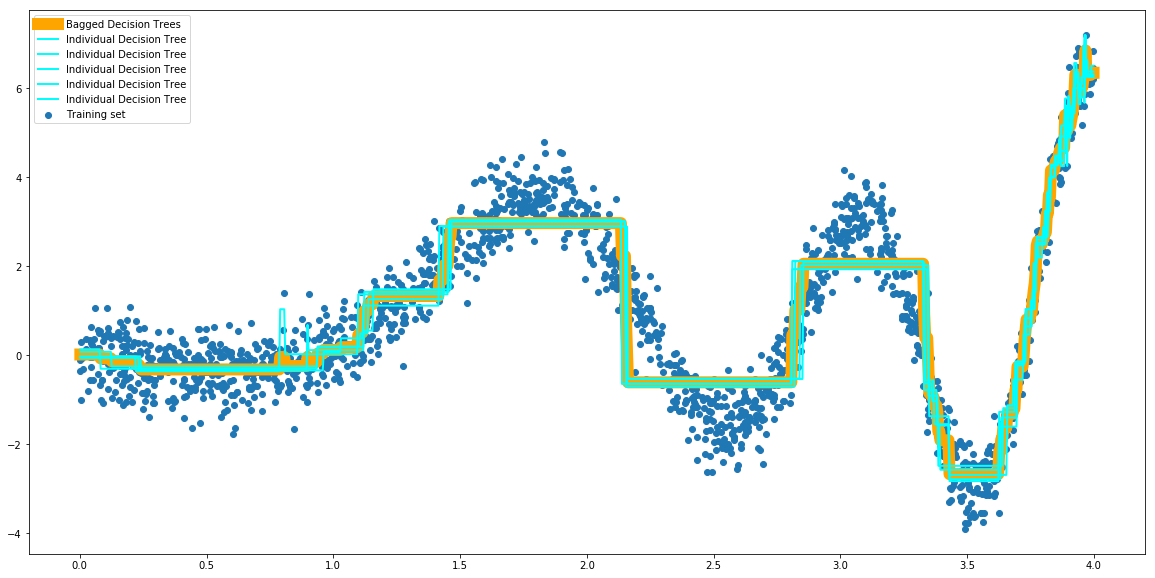

In [11]:
plt.figure(figsize=(20,10)) #Make figure big so we can see all of the lines
plt.scatter(bag.train[bag.features], bag.train[bag.target], label = 'Training set')
plt.plot(bag.regLineDF['X'], bag.regLineDF['Pred'], linestyle = 'solid', linewidth = 12,color = 'orange', label = 'Bagged Decision Trees')
for i in range((len(bag.forest))):
    plt.plot(bag.regLineDF['X'], bag.regLineDF[f'Pred{i}'], linestyle = 'solid', linewidth = 2,color = 'cyan', label = 'Individual Decision Tree')
plt.legend()
plt.show()


Each of the Cyan coloured lines corresponds to an individual decision tree. As we would expect, the Orange line is typically positioned in the middle of the Cyan lines and upon inspection appears to have fewer points where it predicts the target variable poorly compared to the individual decision trees. In particular, as the gradient of the curve rapidly increases towards the end of the curve the number of points used to calculate the predicted value decreases sharply and Bagging reduces the variance in such predictions and helps combat overfitting (although Bagging is not necessarily in general immune to overfitting!)